In [34]:
import torch
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt 
import numpy as np

## Introduction

- Using ResNet50 to classify an image of a pig
- Preprocessing:
    - Scale to 224x224
    - Transform to tensor
    - Add batch size dimension (1)
    - Normalize using the given values for the 3 color channels (Question : Where do these values come from?)
- Loading Classifier:
    - Use pretrained weights from pytorch
    - set to eval mode
    - get prediction using the normalized image as input
    - load class definitions from json file

torch.Size([1, 3, 224, 224])


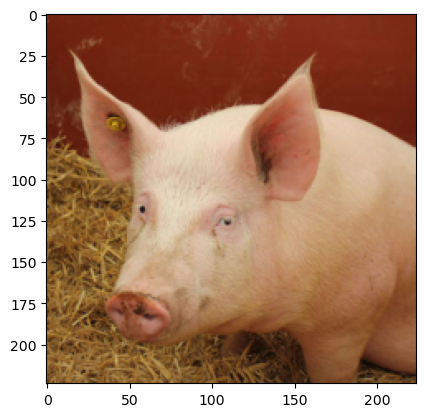

In [31]:
# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:] # Apply scaling, transform to tensor, add dimension of size 1 for batch size (1,3,224,224)
print(pig_tensor.shape)

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In [17]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [18]:
pred = model(norm(pig_tensor))
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


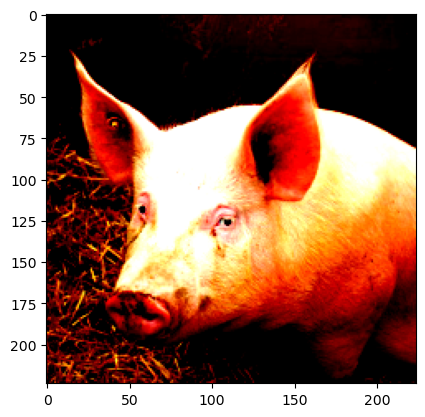

## Loss

In [40]:
# 341 is the class index corresponding to "hog"
hog_loss = nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item()
print(f"{hog_loss=}")
confidence = np.exp(-hog_loss)
print(f"{confidence=}")

hog_loss=0.003882253309711814
confidence=0.9961252728929767


## Generating an adversarial example

Instead of minimizing the loss function by using the gradient to see how small changes in the parameters $\theta$ affect the output, we maximize the loss by using the gradient in respect to small changes in the input image $x$.
Solve the optimization problem:
$$
\begin{align}
\underset{\hat{\delta\in \Delta}}{\text{maximize}}\space l(h_{\theta}(x+\delta),y)
\end{align}
$$
Where $\delta$ is the **perturbation** to $x$ to keep $\hat x$ close to our original image.

In [41]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.003882253309711814
5 -0.006934622768312693
10 -0.01581084169447422
15 -0.08040107786655426
20 -11.296732902526855
25 -14.85807991027832
True class probability: 1.7634958382473087e-08


Predicted class:  wombat
Predicted probability: 0.9999651908874512


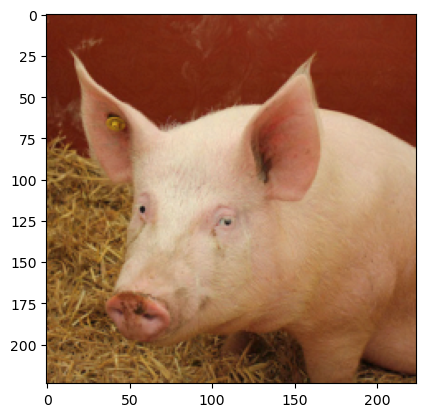

In [43]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))


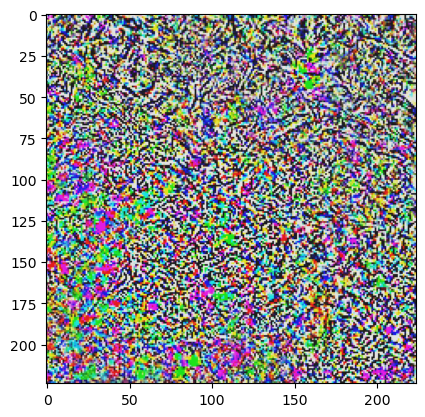

In [44]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
